İmport packages

In [14]:
from numpy import load
from tensorflow import keras
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from matplotlib import pyplot

Discriminator Model

In [ ]:
def define_discriminator(image_shape):
  # weight initialization
  init = RandomNormal(stddev=0.02)
  # source image input
  in_src_image = Input(shape=image_shape)
  # target image input
  in_target_image = Input(shape=image_shape)
  # concatenate images channel-wise
  merged = Concatenate()([in_src_image, in_target_image])
  # C64
  d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
  d = LeakyReLU(alpha=0.2)(d)
  # C128
  d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)
  # C256
  d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)
  # C512
  d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)
  # second last output layer
  d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)
  # patch output
  d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
  patch_out = Activation('sigmoid')(d)
  # define model
  model = Model([in_src_image, in_target_image], patch_out)
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
  return model

Encoder block

In [ ]:
def define_encoder_block(layer_in, n_filters, batchnorm=True):
  # weight initialization
  init = RandomNormal(stddev=0.02)
  # add downsampling layer
  g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same',
  kernel_initializer=init)(layer_in)
  # conditionally add batch normalization,
  if batchnorm:
    g = BatchNormalization()(g, training=True)
  # leaky relu activation
  g = LeakyReLU(alpha=0.2)(g)
  return g

Decoder block

In [ ]:
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
  # weight initialization
  init = RandomNormal(stddev=0.02)
  # add upsampling layer
  g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same',
  kernel_initializer=init)(layer_in)
  # add batch normalization
  g = BatchNormalization()(g, training=True)
  # conditionally add dropout
  if dropout:
    g = Dropout(0.5)(g, training=True)
  # merge with skip connection
  g = Concatenate()([g, skip_in])
  # relu activation
  g = Activation('relu')(g)
  return g

Generator Model

In [ ]:
def define_generator(image_shape=(256,256,3)):
  # weight initialization
  init = RandomNormal(stddev=0.02)
  # image input
  in_image = Input(shape=image_shape)
  # encoder model
  e1 = define_encoder_block(in_image, 64, batchnorm=False)
  e2 = define_encoder_block(e1, 128)
  e3 = define_encoder_block(e2, 256)
  e4 = define_encoder_block(e3, 512)
  e5 = define_encoder_block(e4, 512)
  e6 = define_encoder_block(e5, 512)
  e7 = define_encoder_block(e6, 512)
  # bottleneck, no batch norm and relu
  b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
  b = Activation('relu')(b)
  # decoder model
  d1 = decoder_block(b, e7, 512)
  d2 = decoder_block(d1, e6, 512)
  d3 = decoder_block(d2, e5, 512)
  d4 = decoder_block(d3, e4, 512, dropout=False)
  d5 = decoder_block(d4, e3, 256, dropout=False)
  d6 = decoder_block(d5, e2, 128, dropout=False)
  d7 = decoder_block(d6, e1, 64, dropout=False)
  # output
  g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
  out_image = Activation('tanh')(g)
  # define model
  model = Model(in_image, out_image)
  return model

Gan Model


In [ ]:
def define_gan(g_model, d_model, image_shape):
  # make weights in the discriminator not trainable
  d_model.trainable = False
  # define the source image
  in_src = Input(shape=image_shape)
  # connect the source image to the generator input
  gen_out = g_model(in_src)
  # connect the source input and generator output to the discriminator input
  dis_out = d_model([in_src, gen_out])
  # src image as input, generated image and classification output
  model = Model(in_src, [dis_out, gen_out])
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
  return model

Load and prepare training images


In [7]:
def load_real_samples(filename):
  # load the compressed arrays
  data = load(filename)
  # unpack the arrays
  X1, X2 = data['arr_0'], data['arr_1']
  # scale from [0,255] to [-1,1]
  X1 = (X1 - 127.5) / 127.5
  X2 = (X2 - 127.5) / 127.5
  return [X1, X2]

Real samples for discriminator

In [1]:
def generate_real_samples(dataset, n_samples, patch_shape):
  # unpack dataset
  trainA, trainB = dataset
  # choose random instances
  ix = randint(0, trainA.shape[0], n_samples)
  # retrieve selected images
  X1, X2 = trainA[ix], trainB[ix]
  # generate ✬real✬ class labels (1)
  y = ones((n_samples, patch_shape, patch_shape, 1))
  return [X1, X2], y

Fake samples for discriminator

In [3]:
def generate_fake_samples(g_model, samples, patch_shape):
  # generate fake instance
  X = g_model.predict(samples)
  # create ✬fake✬ class labels (0)
  y = zeros((len(X), patch_shape, patch_shape, 1))
  return X, y

Evaluate Model

In [ ]:
def summarize_performance(step, g_model, dataset, n_samples=3):
  # select a sample of input images
  [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
  # generate a batch of fake samples
  X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
  # scale all pixels from [-1,1] to [0,1]
  X_realA = (X_realA + 1) / 2.0
  X_realB = (X_realB + 1) / 2.0
  X_fakeB = (X_fakeB + 1) / 2.0
  # plot real source images
  for i in range(n_samples):
    pyplot.subplot(3, n_samples, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(X_realA[i])
  # plot generated target image
  for i in range(n_samples):
    pyplot.subplot(3, n_samples, 1 + n_samples + i)
    pyplot.axis('off')
    pyplot.imshow(X_fakeB[i])
  # plot real target image
  for i in range(n_samples):
    pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
    pyplot.axis('off')
    pyplot.imshow(X_realB[i])
  # save plot to file
  filename1 = '/content/gdrive/My Drive/Colab Notebooks/Satellite project/plot/plot_%06d.png' % (step+1)
  pyplot.savefig(filename1)
  pyplot.close()
  # save the generator model
  filename2 = '/content/gdrive/My Drive/Colab Notebooks/Satellite project/model/model_%06d.h5' % (step+1)
  g_model.save(filename2)
  print('>Saved: %s and %s' % (filename1, filename2))

Reaching in google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Test your reaching

In [ ]:
!ls /content/gdrive/'My Drive'/'Colab Notebooks'

 CIFAR-10_colorphotographs	    MNIST_handwritten	 Untitled
 inzva_CNN_Image_Processing.ipynb  'Satellite project'


Train Model

In [ ]:
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
  # determine the output square shape of the discriminator
  n_patch = d_model.output_shape[1]
  # unpack dataset
  trainA, trainB = dataset
  # calculate the number of batches per training epoch
  bat_per_epo = int(len(trainA) / n_batch)
  # calculate the number of training iterations
  n_steps = bat_per_epo * n_epochs
  # manually enumerate epochs
  for i in range(n_steps):
    # select a batch of real samples
    [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
    # generate a batch of fake samples
    X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
    # update discriminator for real samples
    d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
    # update discriminator for generated samples
    d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
    # update the generator
    g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
    # summarize performance
    print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
    # summarize model performance
    if (i+1) % (bat_per_epo * 10) == 0:
      summarize_performance(i, g_model, dataset)

In [ ]:
# load image data
dataset = load_real_samples('/content/gdrive/My Drive/Colab Notebooks/Satellite project/maps_256.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
# train model
train(d_model, g_model, gan_model, dataset)

Streaming output truncated to the last 5000 lines.
>6013, d1[0.000] d2[0.001] g[7.234]
>6014, d1[0.000] d2[0.001] g[8.398]
>6015, d1[0.000] d2[0.002] g[11.596]
>6016, d1[0.000] d2[0.001] g[7.291]
>6017, d1[0.000] d2[0.000] g[7.965]
>6018, d1[0.000] d2[0.000] g[7.237]
>6019, d1[0.000] d2[0.000] g[14.658]
>6020, d1[0.000] d2[0.000] g[5.898]
>6021, d1[0.000] d2[0.000] g[11.394]
>6022, d1[0.000] d2[0.000] g[7.019]
>6023, d1[0.000] d2[0.000] g[11.075]
>6024, d1[0.009] d2[0.001] g[6.455]
>6025, d1[0.001] d2[0.001] g[13.421]
>6026, d1[0.001] d2[0.000] g[9.291]
>6027, d1[0.001] d2[0.001] g[11.229]
>6028, d1[0.000] d2[0.001] g[7.076]
>6029, d1[0.001] d2[0.000] g[12.567]
>6030, d1[0.000] d2[0.001] g[7.614]
>6031, d1[0.000] d2[0.000] g[2.481]
>6032, d1[0.001] d2[0.001] g[16.808]
>6033, d1[0.000] d2[0.006] g[6.493]
>6034, d1[0.000] d2[0.001] g[6.611]
>6035, d1[0.000] d2[0.000] g[14.432]
>6036, d1[0.001] d2[0.001] g[8.535]
>6037, d1[0.000] d2[0.000] g[12.359]
>6038, d1[0.000] d2[0.000] g[8.021]
>60

KeyboardInterrupt: ignored

Generate images with trained model that saved in models folder

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [10]:
# load image data
dataset = load_real_samples('/content/gdrive/My Drive/Colab Notebooks/Satellite project/maps_256.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)

Loaded (1096, 256, 256, 3) (1096, 256, 256, 3)


In [15]:
 g_model=keras.models.load_model('/content/gdrive/My Drive/Colab Notebooks/Satellite project/model/model_010960.h5')

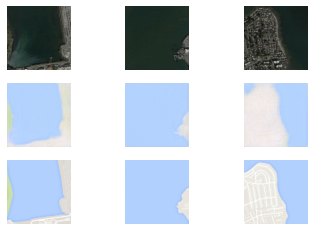

In [21]:
# This result is not good, our model will be good if we contiune training proccess
# select a sample of input images
[X_realA, X_realB], _ = generate_real_samples(dataset,3, 1)
# generate a batch of fake samples
X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
# scale all pixels from [-1,1] to [0,1]
X_realA = (X_realA + 1) / 2.0
X_realB = (X_realB + 1) / 2.0
X_fakeB = (X_fakeB + 1) / 2.0
# plot real source images
n_samples=3
for i in range(n_samples):
  pyplot.subplot(3, n_samples, 1 + i)
  pyplot.axis('off')
  pyplot.imshow(X_realA[i])
# plot generated target image
for i in range(n_samples):
  pyplot.subplot(3, n_samples, 1 + n_samples + i)
  pyplot.axis('off')
  pyplot.imshow(X_fakeB[i])
# plot real target image
for i in range(n_samples):
  pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
  pyplot.axis('off')
  pyplot.imshow(X_realB[i])